# K MEANS

In [1]:
pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Importamos librerias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

# 1.1 Importamos el dataframe

In [3]:
df_completo = pd.read_csv('/workspaces/carlos060495-intro-ml/data/raw/housing.csv')
df_completo.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# 1.2 comprobamos filas y columnas duplicadas

In [4]:
df_completo.duplicated().sum() 

np.int64(0)

In [5]:
df_completo.T.duplicated().sum()

np.int64(0)

# 1.3 comprobamos valores nulos

In [6]:
df_completo.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

# 2.1 Datos para KMEANS 

In [7]:
df_kmeans = df_completo[["MedInc","Latitude", "Longitude"]].copy()
df_kmeans.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


# 2.2 Escalado de datos con MinMaxScaler

In [8]:
# Escalamos todas las variables al rango [0,1]
scaler = MinMaxScaler()
df_kmeans_scaled = pd.DataFrame(
    scaler.fit_transform(df_kmeans),
    columns=df_kmeans.columns,
    index=df_kmeans.index
)

# Comparamos antes y después del escalado
print("Antes del escalado:")
print(df_kmeans.describe())
print("\n" + "="*50 + "\n")
print("Después del escalado:")
print(df_kmeans_scaled.describe())

Antes del escalado:
             MedInc      Latitude     Longitude
count  20640.000000  20640.000000  20640.000000
mean       3.870671     35.631861   -119.569704
std        1.899822      2.135952      2.003532
min        0.499900     32.540000   -124.350000
25%        2.563400     33.930000   -121.800000
50%        3.534800     34.260000   -118.490000
75%        4.743250     37.710000   -118.010000
max       15.000100     41.950000   -114.310000


Después del escalado:
             MedInc      Latitude     Longitude
count  20640.000000  20640.000000  20640.000000
mean       0.232464      0.328572      0.476125
std        0.131020      0.226988      0.199555
min        0.000000      0.000000      0.000000
25%        0.142308      0.147715      0.253984
50%        0.209301      0.182784      0.583665
75%        0.292641      0.549416      0.631474
max        1.000000      1.000000      1.000000


# 2.3 Método del codo con datos escalados

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

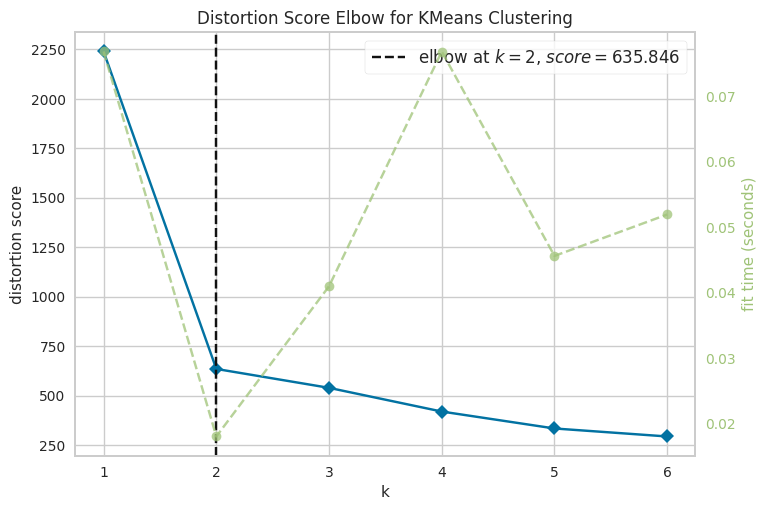

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
kmeans = KMeans(random_state=42)

elbow_visualizer = KElbowVisualizer(kmeans, k=(1,7))
elbow_visualizer.fit(df_kmeans_scaled)
elbow_visualizer.show()


# 2.4 Silhouette Score

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

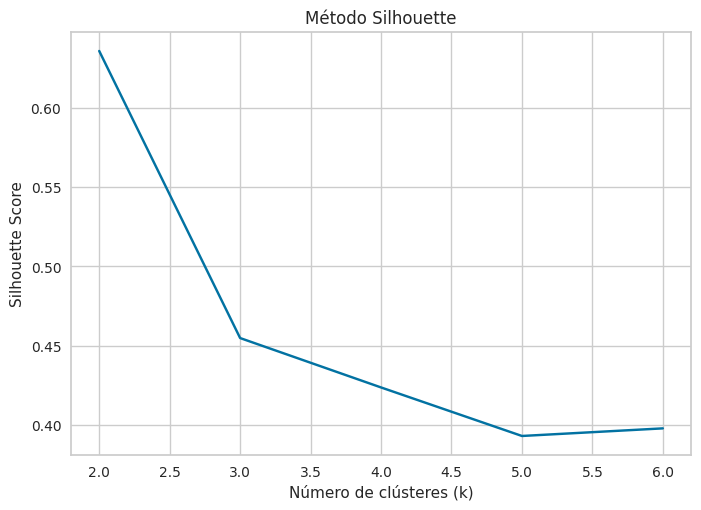

In [10]:
silhouette_scores = []

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_kmeans_scaled)
    clusters = kmeans.predict(df_kmeans_scaled)
    silhouette_scores.append(silhouette_score(df_kmeans_scaled, clusters))
plt.plot(range(2, 7), silhouette_scores)
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Silhouette Score')
plt.title('Método Silhouette')
plt.show()

# 2.5 Davies Bouldin Score

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

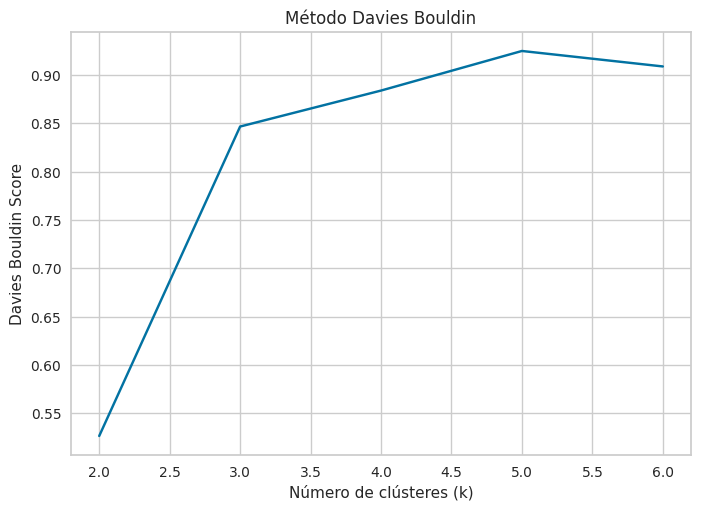

In [11]:
db_scores = []

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_kmeans_scaled)
    clusters = kmeans.predict(df_kmeans_scaled)
    db_scores.append(davies_bouldin_score(df_kmeans_scaled, clusters))

plt.plot(range(2, 7), db_scores)
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Davies Bouldin Score')
plt.title('Método Davies Bouldin')
plt.show()

In [ ]:
# Guardamos los cluster en el dataframe original
df_completo['Cluster'] = kmeans.predict(df_kmeans_scaled)

print("Distribución de los 6 clusters:")
print(df_completo['Cluster'].value_counts().sort_index())

Distribución de los 6 clusters:
Cluster
0    8134
1    5021
2    1710
3    2985
4    1885
5     905
Name: count, dtype: int64


In [13]:
df_completo.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,Cluster
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,4
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,4
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,4
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,4
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,1
